# ltu-ili jupyter interface
This is a tutorial for using the ltu-ili inference framework in a jupyter notebook. 

This notebook assumes you have installed the ltu-ili package from the installation instructions in [INSTALL.md](../INSTALL.md).

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import torch
from torch.distributions import Uniform, ExpTransform, TransformedDistribution #, AffineTransform

import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

from sbi.utils.user_input_checks import process_prior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


# Get theta

In [2]:
df_pars = pd.read_csv('/home/jovyan/camels/LH/CosmoAstroSeed_IllustrisTNG_L25n256_LH.txt', delim_whitespace=True)
df_pars

,#Name,Omega_m,sigma_8,A_SN1,A_AGN1,A_SN2,A_AGN2,seed
0,LH_0,0.3090,0.9790,3.11234,1.12194,0.66850,0.53182,0
1,LH_1,0.3026,0.9394,3.42001,3.96137,1.03311,1.16070,1
2,LH_2,0.4282,0.7530,0.70613,0.37423,1.96292,0.62720,2
3,LH_3,0.1906,0.6286,1.60882,0.39887,0.86634,0.86634,3
4,LH_4,0.1382,0.6874,1.19914,0.27586,0.82188,0.91700,4
...,...,...,...,...,...,...,...,...
995,LH_995,0.1342,0.7202,0.48163,0.25174,1.74231,0.76684,995
996,LH_996,0.1854,0.7978,0.30566,1.79751,1.51887,0.53403,996
997,LH_997,0.1582,0.7854,0.93952,2.23148,1.85446,1.32961,997
998,LH_998,0.3854,0.9778,0.93692,0.42869,1.48761,1.32042,998


In [3]:
theta = df_pars[['Omega_m', 'sigma_8', 'A_SN1', 'A_AGN1', 'A_SN2', 'A_AGN2']].to_numpy()
print(theta)
print(theta.shape)

[[0.309   0.979   3.11234 1.12194 0.6685  0.53182]
 [0.3026  0.9394  3.42001 3.96137 1.03311 1.1607 ]
 [0.4282  0.753   0.70613 0.37423 1.96292 0.6272 ]
 ...
 [0.1582  0.7854  0.93952 2.23148 1.85446 1.32961]
 [0.3854  0.9778  0.93692 0.42869 1.48761 1.32042]
 [0.4322  0.6142  1.28521 0.35799 1.1591  0.86754]]
(1000, 6)


# Get data (x)

In [4]:
import os
import pandas as pd

# Define the directory containing the LH_X files
directory = "/home/jovyan/camels/LH/get_LF/output/"

# Get all files in the directory
files = os.listdir(directory)

# Filter out files that start with "LH_" and end with ".txt"
LH_X_files = [file for file in files if file.startswith("LH_") and file.endswith(".txt")]

# Initialize lists to store data
phia = []
phi_sigmaa = []
binsa = []
LH_X_values = []

# Iterate over LH_X files
for LH_X_file in LH_X_files:
    # Define the file path
    file_path = os.path.join(directory, LH_X_file)
    
    # Extract LH_X value from the file name (remove the ".txt" extension)
    LH_X = LH_X_file[:-4]
    
    # Initialize an empty dictionary to store variable names and their values
    variable_data = {}

    # Open the text file for reading
    with open(file_path, 'r') as file:
        # Initialize variables to store the current variable name and its values
        current_variable_name = None
        current_variable_values = []

        # Iterate over each line in the file
        for line in file:
            # Remove leading and trailing whitespace from the line
            line = line.strip()

            # Check if the line is empty
            if not line:
                continue

            # Check if the line is a variable name
            if line in ['phi', 'phi_sigma', 'hist', 'massBinLimits']:
                # If it's a new variable name, update the current variable name and reset the values list
                if current_variable_name is not None:
                    variable_data[current_variable_name] = current_variable_values
                    current_variable_values = []

                current_variable_name = line
            else:
                # If it's not a variable name, convert the value to float and append it to the values list
                current_variable_values.append(float(line))

        # Add the last variable data to the dictionary
        if current_variable_name is not None:
            variable_data[current_variable_name] = current_variable_values
        
        # Extract specific variables
        phi = variable_data.get('phi')
        phi_sigma = variable_data.get('phi_sigma')
        bins = variable_data.get('massBinLimits')

        phia.append(phi)
        phi_sigmaa.append(phi_sigma)
        binsa.append(bins)
        LH_X_values.append(LH_X)

# Create a DataFrame from the lists
df_x = pd.DataFrame({'LH_X': LH_X_values, 'phi': phia, 'phi_sigma': phi_sigmaa, 'bins': binsa})

# Display the DataFrame
df_x


,LH_X,phi,phi_sigma,bins
0,LH_0,"[0.00015987453159307786, 0.0002213647360519539...","[4.434121702304844e-05, 5.217616865930228e-05,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
1,LH_1,"[1.2298040891775219e-05, 1.2298040891775219e-0...","[1.2298040891775219e-05, 1.2298040891775219e-0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
2,LH_10,"[0.0, 6.143559877543997e-05, 6.143559877543997...","[0.0, 2.7474835020057322e-05, 2.74748350200573...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
3,LH_100,"[0.0, 1.2298040891775219e-05, 4.91921635671008...","[0.0, 1.2298040891775219e-05, 2.45960817835504...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
4,LH_101,"[0.00016015885983260023, 0.0002094385090118618...","[4.442007548817616e-05, 5.079629968986957e-05,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
...,...,...,...,...
995,LH_995,"[1.2319912294815403e-05, 7.391947376889241e-05...","[1.2319912294815403e-05, 3.0177498798138694e-0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
996,LH_996,"[1.2319912294815403e-05, 7.391947376889241e-05...","[1.2319912294815403e-05, 3.0177498798138694e-0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
997,LH_997,"[1.2319912294815403e-05, 0.0, 8.62393860637078...","[1.2319912294815403e-05, 0.0, 3.25954241062086...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
998,LH_998,"[0.0, 4.9192163567100876e-05, 9.83843271342017...","[0.0, 2.4596081783550438e-05, 3.47841124395348...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."


In [5]:
df_x['phi']

0      [0.00015987453159307786, 0.0002213647360519539...
1      [1.2298040891775219e-05, 1.2298040891775219e-0...
2      [0.0, 6.143559877543997e-05, 6.143559877543997...
3      [0.0, 1.2298040891775219e-05, 4.91921635671008...
4      [0.00016015885983260023, 0.0002094385090118618...
                             ...                        
995    [1.2319912294815403e-05, 7.391947376889241e-05...
996    [1.2319912294815403e-05, 7.391947376889241e-05...
997    [1.2319912294815403e-05, 0.0, 8.62393860637078...
998    [0.0, 4.9192163567100876e-05, 9.83843271342017...
999    [4.9192163567100876e-05, 3.689412267532566e-05...
Name: phi, Length: 1000, dtype: object

In [6]:
type(df_x['phi'])

pandas.core.series.Series

In [7]:
# convert pandas series to np.array
x = np.array(df_x['phi'].tolist())
x.shape # shape 11 because they are in 11 bins

(1000, 11)

## Toy NPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

In [8]:
# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

In [9]:
print(loader)

In [10]:
theta

array([[0.309  , 0.979  , 3.11234, 1.12194, 0.6685 , 0.53182],
       [0.3026 , 0.9394 , 3.42001, 3.96137, 1.03311, 1.1607 ],
       [0.4282 , 0.753  , 0.70613, 0.37423, 1.96292, 0.6272 ],
       ...,
       [0.1582 , 0.7854 , 0.93952, 2.23148, 1.85446, 1.32961],
       [0.3854 , 0.9778 , 0.93692, 0.42869, 1.48761, 1.32042],
       [0.4322 , 0.6142 , 1.28521, 0.35799, 1.1591 , 0.86754]])

In [11]:
type(x)

numpy.ndarray

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([0.1002 , 0.14016, 0.18012, 0.22008, 0.26004, 0.3    , 0.33996,
        0.37992, 0.41988, 0.45984, 0.4998 ]),
 <BarContainer object of 10 artists>)

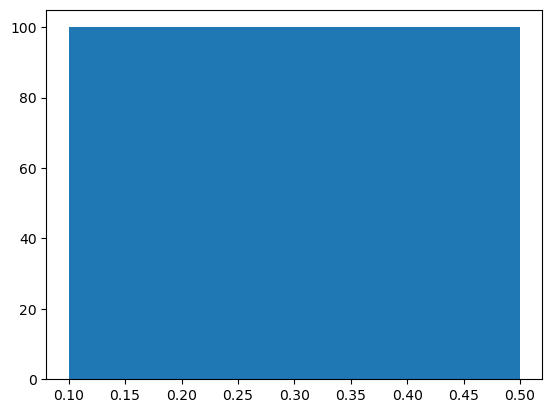

In [12]:
# prior for omega m, between 0.1 and 0.5
plt.hist(theta[:, 0])

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100.]),
 array([0.6002 , 0.64016, 0.68012, 0.72008, 0.76004, 0.8    , 0.83996,
        0.87992, 0.91988, 0.95984, 0.9998 ]),
 <BarContainer object of 10 artists>)

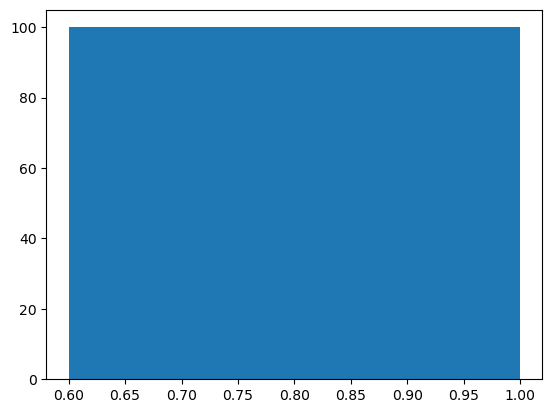

In [13]:
# prior for sigma_8, between 0.6 and 1
plt.hist(theta[:, 1])

(array([330., 170., 114.,  87.,  70.,  59.,  50.,  45.,  39.,  36.]),
 array([0.25035 , 0.624761, 0.999172, 1.373583, 1.747994, 2.122405,
        2.496816, 2.871227, 3.245638, 3.620049, 3.99446 ]),
 <BarContainer object of 10 artists>)

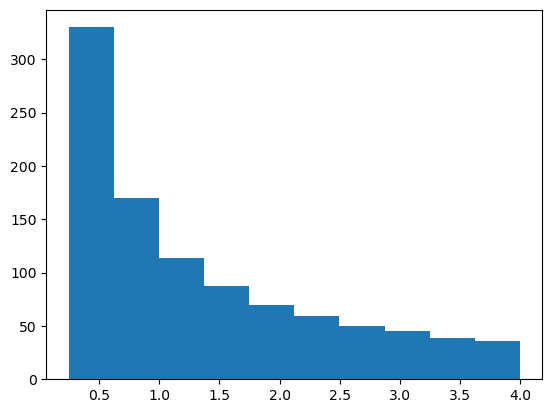

In [14]:
# prior for A_SN1, between 0.25 and 4
plt.hist(theta[:, 2])

(array([330., 170., 114.,  87.,  70.,  59.,  50.,  45.,  39.,  36.]),
 array([0.25035 , 0.624761, 0.999172, 1.373583, 1.747994, 2.122405,
        2.496816, 2.871227, 3.245638, 3.620049, 3.99446 ]),
 <BarContainer object of 10 artists>)

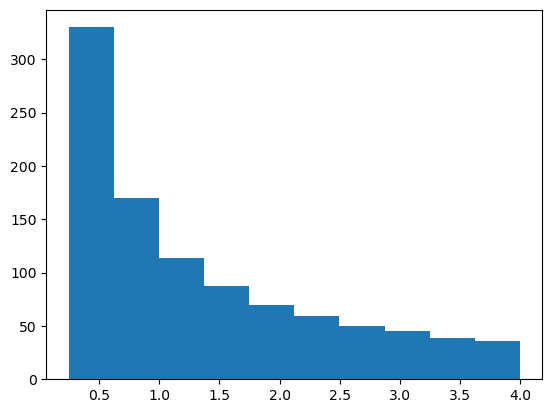

In [15]:
# prior for A_AGN1, between 0.25 and 4
plt.hist(theta[:, 3])

(array([189., 150., 124., 106.,  92.,  81.,  74.,  66.,  61.,  57.]),
 array([0.50035 , 0.650176, 0.800002, 0.949828, 1.099654, 1.24948 ,
        1.399306, 1.549132, 1.698958, 1.848784, 1.99861 ]),
 <BarContainer object of 10 artists>)

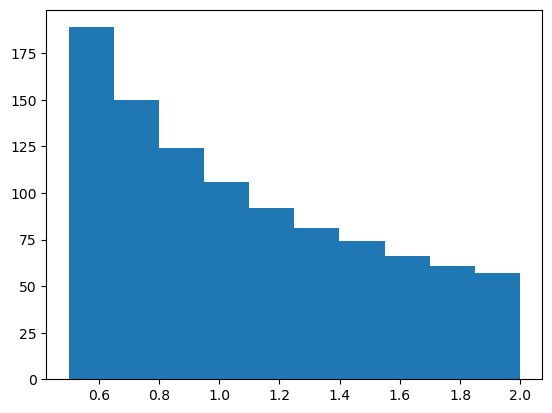

In [16]:
# prior for A_SN2, between 0.5 and 2
plt.hist(theta[:, 4])

(array([189., 150., 124., 106.,  92.,  81.,  74.,  66.,  61.,  57.]),
 array([0.50035 , 0.650176, 0.800002, 0.949828, 1.099654, 1.24948 ,
        1.399306, 1.549132, 1.698958, 1.848784, 1.99861 ]),
 <BarContainer object of 10 artists>)

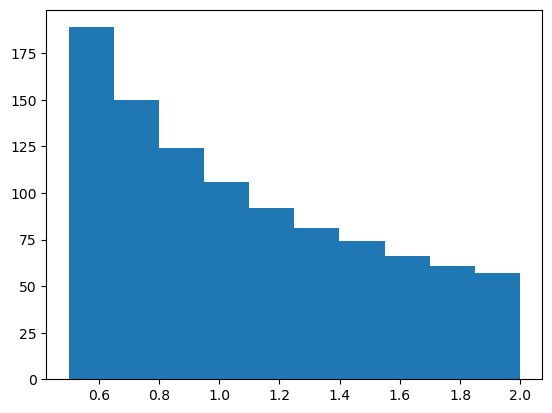

In [17]:
# prior for A_AGN2, between 0.5 and 2
plt.hist(theta[:, 5])

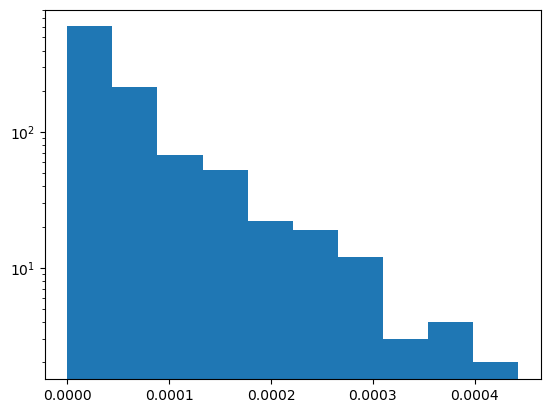

In [18]:
# this is your posterior - predicted value of the luminosity function...?
# maybe log it
plt.hist(x[:, 0])
plt.yscale('log')

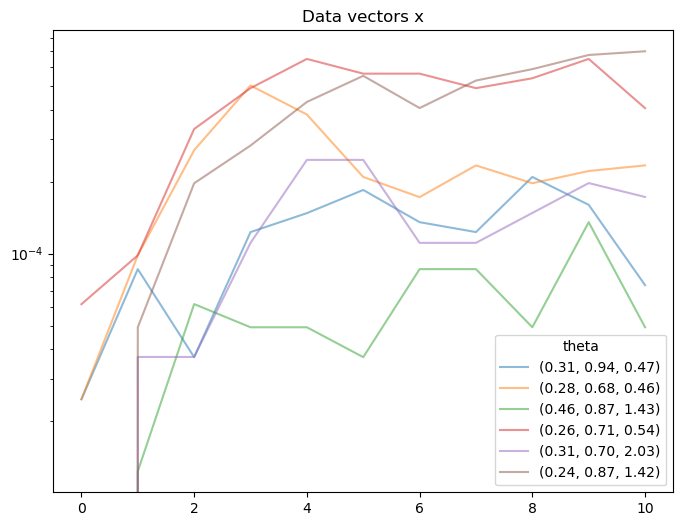

In [19]:
# Plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(6):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'({theta[ind, 0]:.2f}, {theta[ind, 1]:.2f}, {theta[ind, 2]:.2f})')
ax.set_yscale('log')
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

The SBIRunner object will handle all of the data normalization and model training for us. We just need to provide it with:
- our parameter prior
- our inference type (SNPE/SNLE/SNRE)
- our desired neural network architecture
- our training hyperparameters

On the backend, it does a validation split among the provided training data, trains the neural networks with an Adam optimizer, and enforces an early stopping criterion to prevent overfitting. All the parameters of these processes can be independently configured.

In [20]:
def initialise_priors(device="cpu", astro=True, dust=True):

    combined_priors = []

    if astro:
        base_dist1 = Uniform(
            torch.log(torch.tensor([0.25], device=device)),
            torch.log(torch.tensor([4], device=device)),
        )
        base_dist2 = Uniform(
            torch.log(torch.tensor([0.5], device=device)),
            torch.log(torch.tensor([2], device=device)),
        )
        astro_prior1 = TransformedDistribution(base_dist1, ExpTransform())
        astro_prior2 = TransformedDistribution(base_dist2, ExpTransform())
        omega_prior = Uniform(
            torch.tensor([0.1], device=device),
            torch.tensor([0.5], device=device),
        )
        sigma8_prior = Uniform(
            torch.tensor([0.6], device=device),
            torch.tensor([1.0], device=device),
        )
        combined_priors += [
            omega_prior,# prior for omega m, between 0.1 and 0.5: uniform
            sigma8_prior,# prior for sigma_8, between 0.6 and 1: uniform
            astro_prior1,# prior for A_SN1, between 0.25 and 4: exponential
            astro_prior1,# prior for A_AGN1, between 0.25 and 4: exponential
            astro_prior2,# prior for A_SN2, between 0.5 and 2: exponential
            astro_prior2,# prior for A_AGN2, between 0.5 and 2: exponential
        ]

    prior = process_prior(combined_priors)

    return prior[0]

In [21]:
prior = initialise_priors()
print(prior)

MultipleIndependent()


## Toy NLE
This example uses the same dataset as the previous SNPE example, but uses a likelihood estimation model instead of an amortized posterior estimation.

In [22]:
# loader and priors already defined above.

In [23]:

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NLE', model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NLE', model='made', hidden_features=50, num_transforms=5),
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NLE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [24]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NLE
INFO:root:Training model 1 / 2.


 Training neural network. Epochs trained: 251

INFO:root:Training model 2 / 2.


 Neural network successfully converged after 196 epochs.

INFO:root:It took 8785.811282157898 seconds to train models.


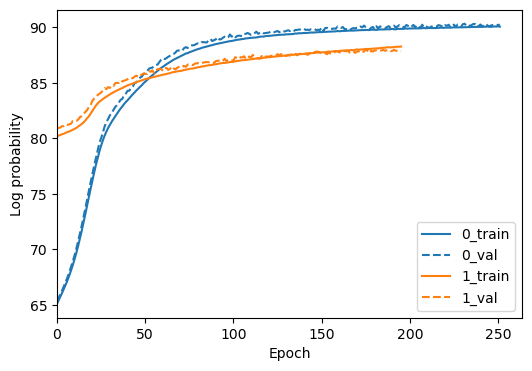

In [25]:
# plot train/validation loss
f, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
seed_ind = 24
np.random.seed(seed_ind)
ind = np.random.randint(len(theta))

# generate samples from the posterior using MCMC
samples = posterior_ensemble.sample(
    (1000,), x[ind], 
    method='slice_np_vectorized', num_chains=6
).detach().cpu().numpy()

# calculate the potential (prop. to log_prob) for each sample
log_prob = posterior_ensemble.log_prob(
    samples, 
    x[ind]
).detach().cpu().numpy()

Running vectorized MCMC with 6 chains:   0%|          | 0/9792 [00:00<?, ?it/s]

Running vectorized MCMC with 6 chains:   0%|          | 0/1410 [00:00<?, ?it/s]

In [28]:
theta

array([[0.309  , 0.979  , 3.11234, 1.12194, 0.6685 , 0.53182],
       [0.3026 , 0.9394 , 3.42001, 3.96137, 1.03311, 1.1607 ],
       [0.4282 , 0.753  , 0.70613, 0.37423, 1.96292, 0.6272 ],
       ...,
       [0.1582 , 0.7854 , 0.93952, 2.23148, 1.85446, 1.32961],
       [0.3854 , 0.9778 , 0.93692, 0.42869, 1.48761, 1.32042],
       [0.4322 , 0.6142 , 1.28521, 0.35799, 1.1591 , 0.86754]])

Note: Amortized liklihood estimators do not directly estimate the posterior, but instead build a model for the relative likelihood. This can be combined with a prior to estimate the potential function, which is proportional to the log_probability up to a normalizing constant. Hence, we use MCMC sampling for SNLE models to probe the posterior distribution.

In [29]:
theta.shape

(1000, 6)

In [30]:
# plot the posterior samples and the true value
f, axs = plt.subplots(1, 6, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(6):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='potential', use_gridspec=True, cax=axs[2])

ValueError: Expected the given number of width ratios to match the number of columns of the grid

<Figure size 1000x400 with 0 Axes>

### (We will sample only from the ensemble posterior in this section)

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PosteriorCoverage(
    num_samples=1000, sample_method='vi',
    sample_params={'dist': 'maf', 'n_particles': 32, 'learning_rate': 1e-2},
    labels=[f'$\\theta_{i}$' for i in range(6)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"]
)

# Drawing samples from the ensemble posterior
fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

Looks like we're well-calibrated in both univariate and multivariate tests, with much tighter constraints on $\theta_1$ than the SNPE!

## CAMELS CMD 2D NPE
The real utility of ltu-ili is in its flexibility for applicaiton to a wide variety of real datasets. Through the use of customizable embedding networks, this framework can be extended to handle e.g. image, point cloud, or time-series inputs.

In this example, our inputs are 2D slices of the gas temperature of the simulations in the [CAMELS Multifield Dataset](https://camels-multifield-dataset.readthedocs.io/en/latest/) and our target parameters are 6 cosmological and astrophysical parameters (Omega_m, sigma_8, A_SN1, A_AGN1, A_SN2, A_AGN2) that were used to run the simulation. This inference pipeline follows the procedure of the [CAMELS 2D Inference colab example](https://colab.research.google.com/drive/1-BmkA8JSc36O8g9pj7FenD1YSLKqjQR3?usp=sharing).

In [ ]:
# Download CAMELS 2D maps and latin hypercube parameters (~3.2 GB)
import os
os.makedirs('./toy', exist_ok=True)
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/Maps_T_IllustrisTNG_LH_z=0.00.npy -o ./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy
!curl https://users.flatironinstitute.org/~fvillaescusa/priv/DEPnzxoWlaTQ6CjrXqsm0vYi8L7Jy/CMD/2D_maps/data/params_LH_IllustrisTNG.txt -o ./toy/params_LH_IllustrisTNG.txt

In [ ]:
# load data
x = np.log10(np.load('./toy/Maps_T_IllustrisTNG_LH_z=0.00.npy'))
theta = np.loadtxt('./toy/params_LH_IllustrisTNG.txt')
theta = np.repeat(theta, 15, axis=0)

# subsample (for speed)
x = x[::2]
theta = theta[::2]

# conform images to pytorch expected shape
x = x[:,None,...]

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

# determine prior bounds
prior_min = theta.min(axis=0)
prior_max = theta.max(axis=0)

In [ ]:
labels = [r'$\Omega_m$', r'$\sigma_8$', r'$A_{SN1}$',
          r'$A_{AGN1}$', r'$A_{SN2}$', r'$A_{AGN2}$']

# plot a few examples of the data
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ind = np.random.randint(len(x))
    im = axs[i].imshow(x[ind,0], cmap='RdBu_r')

    title = [f'{labels[j]}={theta[ind,j]:.2f}' for j in range(6)]
    title.insert(3, '\n')
    axs[i].set_title(' '.join(title))
    axs[i].axis('off')

In [ ]:
# let's build a convolutional embedding network for processing images

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=8, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [ ]:
# define a prior
prior = ili.utils.Uniform(low=prior_min, high=prior_max, device=device)

# instantiate a CNN embedding network
embedding_net = ConvNet()

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=50, num_transforms=5,
                           embedding_net=embedding_net),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=6,
                           embedding_net=embedding_net)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-5,
    'stop_after_epochs': 50
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=embedding_net,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [ ]:
# train the model. this outputs a posterior model and training logs
posterior_ensemble, summaries = runner(loader=loader)

In [ ]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [ ]:
# choose a random input
ind = np.random.randint(len(theta))
x_test = torch.Tensor(x[ind]).to(device)

# generate samples from the posterior using accept/reject sampling
samples = posterior_ensemble.sample((1000,), x_test)
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_test)

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

In [ ]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(6):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_xlim(prior_min[i], prior_max[i])
    axs[i].set_ylim(prior_min[i+1], prior_max[i+1])
    axs[i].set_xlabel(labels[i])
    axs[i].set_ylabel(labels[i+1])
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

In [ ]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=labels, out_dir=None
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind],
)

In [ ]:
# calculate and plot the rank statistics to describe univariate posterior coverage
metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=posterior_ensemble,
    x=x[::8], theta=theta[::8]
)

As you can see, we are picking up on clear information on $\Omega_m$ and some on $\sigma_8$ and $A_\mathrm{SN1}$, but not much on the other parameters. This mimics the finding of the CAMELS CMD example, albeit with worse constraints (likely since we have not optimized our CNN architecture). We can see that in the parameters which we can constrain well, we are fairly well-calibrated, but on the whole our posteriors are slightly negatively biased. This is likely the result of the limited prior range, which is cutting off the tails of the posterior for the unconstrained variables.

Nonetheless, this demonstrates how the ltu-ili framework can be used to perform inference on real datasets using customizable embedding networks.